# Discriminators to approximate probability densities

In this notebook, we will show how to use a discriminator to learn and approximate probability distribution.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.autograd import Variable
%matplotlib inline

In [2]:
class Discriminator(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super(Discriminator, self).__init__()
        self.l1 = torch.nn.Linear(in_features, 30)
        self.l2 = torch.nn.Linear(30, 20)
        self.l3 = torch.nn.Linear(20, 10)
        self.l4 = torch.nn.Linear(10, out_features)
        self.relu = torch.nn.ReLU()
        self.bce = torch.nn.BCEWithLogitsLoss()
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        a1 = self.relu(self.l1(x))
        a2 = self.relu(self.l2(a1))
        a3 = self.relu(self.l3(a2))
        return self.l4(a3)
    
    def forward_with_sigmoid(self, x):
        return self.sigmoid(self.forward(x))
    
    def loss(self, x, y):
        y_hat_logits = self.forward(x)
        return self.bce(y_hat_logits, y)
       

In [3]:
x_1 = np.random.uniform(size=(3000,2), low=-3, high=8)
x_2 = np.random.normal(loc=np.array([3.0,3.]), size=(3000,2))

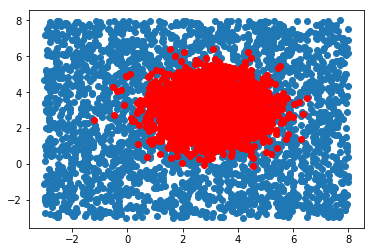

In [4]:
plt.scatter(x_1[:, 0], x_1[:, 1])
plt.scatter(x_2[:, 0], x_2[:, 1], c='r')

In [5]:
x = np.concatenate([x_1, x_2], axis=0)
y = np.concatenate([np.zeros(x_1.shape[0]), np.ones(x_2.shape[0])], axis=0)

In [6]:
discriminator = Discriminator(2, 1)
opt = torch.optim.Adam(discriminator.parameters(), lr=0.001)

In [7]:
def plot(disc):
    h=0.1
    x_min, x_max = x[:, 0].min() - .5, x[:, 0].max() + .5
    y_min, y_max = x[:, 1].min() - .5, x[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    x_test = np.c_[xx.ravel(), yy.ravel()]
    y_hat_test = disc.forward_with_sigmoid(Variable(torch.from_numpy(x_test).float()))

    plt.pcolormesh(xx, yy, y_hat_test.data.numpy().reshape(xx.shape), cmap=plt.cm.Paired)
    plt.colorbar()
    plt.scatter(x[:, 0], x[:, 1], c=y*20, alpha=0.1, cmap=plt.cm.flag)
    plt.show()

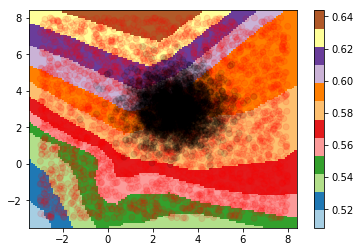

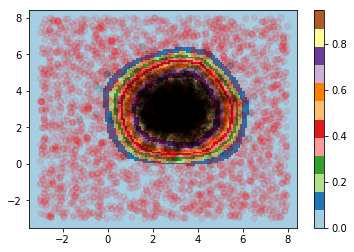

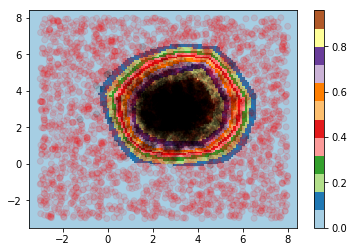

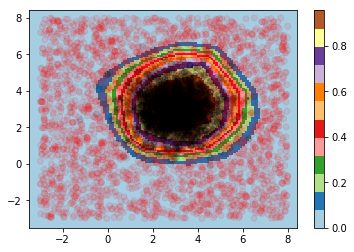

In [8]:
index = np.arange(x.shape[0])
batch_size = 50
for i in range(20000):
    mask = np.random.choice(index, batch_size)
    x_t = Variable(torch.from_numpy(x[mask]).float())
    y_t = Variable(torch.from_numpy(y[mask].reshape(-1,1)).float())
    opt.zero_grad()
    loss = discriminator.loss(x_t, y_t)
    loss.backward()
    opt.step()    
    if i%5000 ==0:
        plot(discriminator)

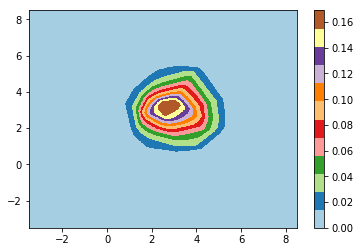

In [16]:
h=0.01
x_min, x_max = x[:, 0].min() - .5, x[:, 0].max() + .5
y_min, y_max = x[:, 1].min() - .5, x[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

x_test = np.c_[xx.ravel(), yy.ravel()]
y_hat_test = discriminator.forward_with_sigmoid(Variable(torch.from_numpy(x_test).float()))

z =y_hat_test.data.numpy().reshape(xx.shape)

z = (z/(1-z))*(1/11**2)

plt.pcolormesh(xx, yy, z, cmap=plt.cm.Paired)
plt.colorbar()
# plt.scatter(x[:, 0], x[:, 1], c=y*20, alpha=0.1, cmap=plt.cm.flag)

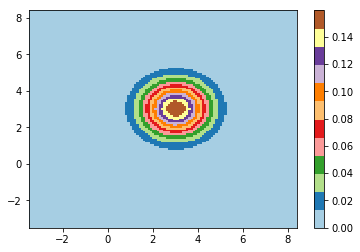

In [17]:
from scipy.stats import multivariate_normal

h=0.1
x_min, x_max = x[:, 0].min() - .5, x[:, 0].max() + .5
y_min, y_max = x[:, 1].min() - .5, x[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

x_test = np.c_[xx.ravel(), yy.ravel()]
y_hat_test = discriminator.forward(Variable(torch.from_numpy(x_test).float()))

z = multivariate_normal.pdf(x_test, mean=np.array([3.0,3.])) # Ratio of probabilities (11**2)

plt.pcolormesh(xx, yy, z.reshape(xx.shape), cmap=plt.cm.Paired)
plt.colorbar()

# Summary

As seen in these two plots, we can use can to learn approximate probabilities using discriminators - in this example we used a simple uniform vs normal distribution. Whilst it is not perfect, its clearly a reasonable approximation to the ground truth, and importantly allows us to translate the problem of learning an approximate distribution into one which is a standard supervised learning optimisation problem.